In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time, sys, os

directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.rcParams['figure.dpi']=400

In [3]:
def ferromagnetic_state_MPS(L):
    
    # given L, returns the MPS tensors of the ferromagnetic state.
    
    mps_tensors= []
    
    A = np.zeros((1, 2, 1), dtype = complex)
    A[0, 0, 0] = 1
    A[0, 1, 0] = 0
    
    for i in range(L):
        mps_tensors.append(A)

    return mps_tensors

## Useful troubleshooting code

In [4]:
def mps(psi, k):

    # Converts a wavefunction into mps form
    
    mps_tensors = []
    L = int(np.log2(len(psi)))  # Number of spins/sites
    psi_matrix = psi.reshape(2, 2**(L-1))

    for i in range(L-1):
        
        U, S, Vh = np.linalg.svd(psi_matrix, full_matrices=False)
        
        chi = min(k, len(S))
        
        S_truncated = S[: chi]
        U_truncated = U[:, :chi]
        Vh_truncated = Vh[:chi, :]

        mps_tensors.append(U_truncated.reshape((-1, 2, chi)))

        if i < L - 2:
            psi_matrix = (np.diag(S_truncated) @ Vh_truncated).reshape(2*chi, -1)
            
        else:
            last_tensor = (np.diag(S_truncated) @ Vh_truncated)
            mps_tensors.append(last_tensor.reshape(chi, 2, -1))

    return mps_tensors

def contract_mps_tensors(mps_tensors):

    # converts mps tensor form to a usual column vector wave-function.
    
    state = mps_tensors[0]
    
    for tensor in mps_tensors[1:]: 
        state = np.einsum('ijk,kln->ijln', state, tensor).reshape(1, -1, tensor.shape[2])
        
    return state.reshape(-1)

## Hamiltonian

In [5]:
def denseH(L, J, hx, hz, periodic):
    """
    generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim)) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx # contribution by sigma^j_x
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   

In [6]:
def inner_product(bra, ket):

    # function to output <psi|psi> when given in MPS form 
    
    result = np.einsum('jkl,mkn->ln', bra[0].conj(), ket[0])

    for i in range(1, len(ket)):

        A = np.einsum('jkl,mkn->jmln', bra[i].conj(), ket[i])
        result = np.einsum('jm,jmln->ln', result, A)

    return result.reshape(-1)[0]

## Function to calculate expectation value of Energy in MPS

In [7]:
def magnetic_term(ket, hx, hz):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(L):
        
        Hket = [np.copy(k) for k in ket]
    
        Hket[i] = hx*np.einsum('ij,kjm->kim', X, ket[i]) + hz*np.einsum('ij,kjm->kim', Z, ket[i])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)
        

def ising_term(ket):
    
    Z = np.array([[1,0],[0,-1]])
    L = len(ket)
    results = np.zeros(L, dtype = complex)
    
    for i in range(0, L-1):
        
        Hket = [np.copy(k) for k in ket]
        
        Hket[i] = np.einsum('ij,kjm->kim', Z, ket[i])
        
        Hket[i+1] = np.einsum('ij,kjm->kim', Z, ket[i+1])
        
        results[i] = inner_product(ket, Hket)
        
    return np.sum(results)

def expectation_value_energy(ket, hx, hz, J):
    
    energy = -magnetic_term(ket, hx, hz)-J*ising_term(ket)
    norm = inner_product(ket, ket)
    
    return energy/norm

In [8]:
def local_gate(dt, hx, hz, ket):
    '''
        Applies the local trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    w = np.array([[-hz, -hx], [-hx, hz]])
    R = scipy.linalg.expm(-1j*dt*w)

    ket_new = []
    
    for i in range(L):
        ket_new.append(np.einsum('ij,kjm->kim', R, ket[i]))

    return ket_new

def twosite_even_gate(dt, J, ket):
    '''
        Applies the even trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0],[0, -1]])
    H = 1j*dt * J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    
    for i in range(0, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))

    if L%2 != 0:
        ket_new.append(ket[L-1])
        
        
    return ket_new

def twosite_odd_gate(dt, J, ket):
    '''
        Applies the odd trotter propagators to the MPS and returns the new MPS
    '''

    L = len(ket)

    Z = np.array([[1, 0], [0, -1]])
    H = 1j*dt* J * np.kron(Z, Z)
    T = scipy.linalg.expm(H).reshape(2, 2, 2, 2)

    ket_new = []
    ket_new.append(ket[0])
    
    for i in range(1, L-1, 2):

        A = np.einsum('ijk,klm->ijlm', ket[i], ket[i+1])
        W = np.einsum('abjl,ijlm->iabm', T, A)
        W = W.reshape(W.shape[0]*W.shape[1], -1)

        U, S, Vh = np.linalg.svd(W, full_matrices=False)
        
        chi = len(S)
        ket_new.append(U.reshape((-1, 2, chi)))
        ket_new.append((np.diag(S) @ Vh).reshape(chi, 2, -1))
    
    if L%2 == 0:
        ket_new.append(ket[L-1])
        
    return ket_new

In [9]:
def canonical_converter(mps_tensors):
    '''
        Converts the tensor into canonical form with the orthogonality center at L
    '''
    new_mps_tensors = mps_tensors.copy()
    L = len(new_mps_tensors)

    for i in range(L-1):
        W = np.einsum('ijk,klm->ijlm', new_mps_tensors[i], new_mps_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = len(S)

        U = U[:, :chi]
        new_mps_tensors[i] = U.reshape(-1, 2, chi)
        
        S = np.diag(S[:chi])
        Vh = Vh[:chi, :]

        new_mps_tensors[i+1] = (S @ Vh).reshape(chi, 2, -1)

    return new_mps_tensors

def bond_dimension_conserver(k, canonical_mps):
    '''
        given a canonical MPS it goes from left to right truncating the schmidt values to k at each step
        it stores U, S, Vh at every cut to help speed up calculations
        returns the values at the cuts from right to left
    '''
    truncated_mps = canonical_mps.copy()
    L = len(canonical_mps)
    canonical_tracker=[]
    canonical_tracker2 = []
    
    for i in range(L-1, 0, -1):
                
        W = np.einsum('ijk,klm->ijlm', truncated_mps[i-1], truncated_mps[i])

        Wmatrix = W.reshape((W.shape[0]*2, -1))
        
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        
        truncated_mps[i] = Vh.reshape(chi, 2, -1)
        
        truncated_mps[i-1] = (U @ np.diag(S[:chi])).reshape(-1, 2, chi)

    canonical_tensors = truncated_mps.copy()
    for i in range(L-1):

        W = np.einsum('ijk,klm->ijlm', canonical_tensors[i], canonical_tensors[i+1])
        Wmatrix = W.reshape((W.shape[0]*2, -1))
    
        U, S, Vh = np.linalg.svd(Wmatrix, full_matrices=False)
        chi = min(k, len(S))
        U = U[:, :chi]
        Vh = Vh[:chi, :]
        canonical_tracker.append([U.reshape(-1, 2, chi), S[:chi], Vh.reshape(chi, 2, -1)])
        canonical_tensors[i+1] = (np.diag(S[:chi])@Vh).reshape(chi, 2, -1)

    a = np.sqrt(np.sum(S[:chi]**2))
    truncated_mps[0] = truncated_mps[0]/a

    return truncated_mps, canonical_tracker
    

### Since we have our MPS in canonical form, we can use it to compute the energies much more efficiently.

In [10]:
def magnetic_term_canonical(canonical_tracker, hx, hz):
    
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])

    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Ssq = np.einsum('ij,kj->ik', S.conj(), S)
        # apply X,Z to U
        ZU = np.einsum('ij,kjm->kim', Z, U)
        XU = np.einsum('ij,kjm->kim', X, U)
        # apply S^2 to U
        ZUS = np.einsum('kim,nm->kin', ZU, Ssq)
        XUS = np.einsum('kim,nm->kin', XU, Ssq)
        
        UhZUS = np.einsum('aib,kin->akbn', U.conj(), ZUS)
        UhXUS = np.einsum('aib,kin->akbn', U.conj(), XUS)

        results[i] = -hz*np.einsum('aabb', UhZUS) - hx*np.einsum('aabb', UhXUS)

    Ssq = np.einsum('ij,ik->jk', S.conj(), S)
    Vh = canonical_tracker[L-2][2]
    
    ZVh = np.einsum('ij,kjm->kim', Z, Vh)
    XVh = np.einsum('ij,kjm->kim', X, Vh)
    
    ZVhS = np.einsum('jk,kim->jim', Ssq, ZVh)
    XVhS = np.einsum('jk,kim->jim', Ssq, XVh)
    
    VZVhS = np.einsum('aib,kin->akbn', Vh.conj(), ZVhS)
    VXVhS = np.einsum('aib,kin->akbn', Vh.conj(), XVhS)

    results[L-1] = -hz *np.einsum('aabb', VZVhS) -hx*np.einsum('aabb', VXVhS)
    
    return np.sum(results)/np.sum(Ssq)

def ising_term_canonical(canonical_tracker, J):
    Z = np.array([[1,0],[0,-1]])
    L = len(canonical_tracker) + 1
    results = np.zeros(L, dtype = complex)

    for i in range(L-1):

        U = canonical_tracker[i][0]
        S = np.diag(canonical_tracker[i][1])
        Vh = canonical_tracker[i][2]

        Uh = U.conj()
        V = Vh.conj()

        US = np.einsum('abc,cd->abd', U, S)
        USVh = np.einsum('abd,def->abef', US, Vh)
        UhS = np.einsum('abc,cd->abd', Uh, S)
        UhSV = np.einsum('abd,def->abef', UhS, V)
        
        ZUSVh = np.einsum('ib,abef->aief', Z, USVh)
        ZUSVhZ = np.einsum('je,aief->aijf', Z, ZUSVh)

        UhSV_ZUSVhZ = np.einsum('abcd,ebcf->aedf', UhSV, ZUSVhZ)

        results[i] = -J*np.einsum('aabb', UhSV_ZUSVhZ)

    return np.sum(results)/np.sum(S**2)
        
def expectation_value_energy_canonical(canonical_tracker, hx, hz, J):
    
    return magnetic_term_canonical(canonical_tracker, hx, hz) + ising_term_canonical(canonical_tracker, J)

## Time to put it all together

In [11]:
def trotter_step(dt, J, hx, hz, ket, k):
    
    evolved_ket = canonical_converter(
        twosite_odd_gate(
            dt, J,
            twosite_even_gate(
                dt, J,
                local_gate(dt, hx, hz, ket.copy())
            )
        )
    )


    return bond_dimension_conserver(k, evolved_ket)
    
def time_evolution(T, J, hx, hz, ket, k, iters):
    
    dt = T/iters
    ket_initial, canonical_tracker =  bond_dimension_conserver(k, ket)
    canonical_trackers = [canonical_tracker]
    evolved_kets = [ket_initial.copy()]
    
    with tqdm(total=iters, desc="Iterations", unit="step") as pbar:
        for i in range(iters):
            evolved_ket, canonical_tracker = trotter_step(dt, J, hx, hz, evolved_kets[-1], k)
            evolved_kets.append(evolved_ket)
            canonical_trackers.append(canonical_tracker)
            pbar.update(1)
        
    return evolved_kets, canonical_trackers

def ground_state(dt, J, hx, hz, ket, k, epsilon=0.0001, max_iterations=1000):
    
    ket_initial, canonical_tracker =  bond_dimension_conserver(k, ket)
    energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
    energies = [energy]
    canonical_trackers = [canonical_tracker]
    evolved_ket = ket.copy()

    with tqdm(total=max_iterations, desc="Iterations", unit="step") as pbar:
        
        for iteration in range(max_iterations):
            evolved_ket, canonical_tracker = trotter_step(dt, J, hx, hz, evolved_ket, k)
            energy = expectation_value_energy_canonical(canonical_tracker, hx, hz, J)
            energies.append(energy)
            canonical_trackers.append(canonical_tracker)
            
            pbar.update(1)
            
            if np.abs((energies[-1]-energies[-2])/energies[-1]) < epsilon:
                break

    return energies[-1], evolved_ket, energies, canonical_trackers
               

In [40]:
L = 12
J = 10
hx = -1.05
hz = 0.5
periodic = False 
dt = 0.01
chi = 16


ket = ferromagnetic_state_MPS(L)

ground_state_energy, evolved_ket, energies_001, canonical_tracker = ground_state(-1j*dt, J, hx, hz, ket, chi, 1e-10, max_iterations=2000)



Iterations:   3%|██                                                                | 62/2000 [00:02<01:10, 27.35step/s]


In [41]:
def correlator_evolution(psi_gs, Egs, T, r, iters, chi):

    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])    
    
    Xket = [np.copy(k) for k in psi_gs]
    Yket = [np.copy(k) for k in psi_gs]
    Zket = [np.copy(k) for k in psi_gs]
    

    Xket[r] = np.einsum('ij,kjm->kim', X, Xket[r])
    Yket[r] = np.einsum('ij,kjm->kim', Y, Yket[r])
    Zket[r] = np.einsum('ij,kjm->kim', Z, Zket[r])
    
    evolved_Xkets, canonical_trackersX = time_evolution(T, J, hx, hz, Xket, chi, iters)
    evolved_Ykets, canonical_trackersY = time_evolution(T, J, hx, hz, Yket, chi, iters)
    evolved_Zkets, canonical_trackersZ = time_evolution(T, J, hx, hz, Zket, chi, iters)

    dt = T/iters

    sigma_xs = []
    sigma_ys = []
    sigma_zs = []
    
    
    for i in range(len(evolved_Xkets)):
        
        evolved_Xket = evolved_Xkets[i]
        evolved_Yket = evolved_Ykets[i]
        evolved_Zket = evolved_Zkets[i]

        t = i*dt

        
        sigma_x = inner_product(Xket, evolved_Xket)*np.exp(1j*t*Egs)
        sigma_y = inner_product(Yket, evolved_Yket)*np.exp(1j*t*Egs)
        sigma_z = inner_product(Zket, evolved_Zket)*np.exp(1j*t*Egs)
        sigma_xs.append(sigma_x)
        sigma_ys.append(sigma_y)
        sigma_zs.append(sigma_z)    
    
    return sigma_xs, sigma_ys, sigma_zs, evolved_Xkets, evolved_Ykets, evolved_Zkets, canonical_trackersX, canonical_trackersY, canonical_trackersZ 

        
        
        
    
    

In [42]:
 sigma_xs, sigma_ys, sigma_zs, evolved_Xkets, evolved_Ykets, evolved_Zkets, canonical_trackersX, canonical_trackersY, canonical_trackersZ   = correlator_evolution(evolved_ket, ground_state_energy, 10, L//2, 1000, 16)

Iterations: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.38step/s]


In [43]:
def entanglement_entropy(l, canonical_tracker):
    s = canonical_tracker[l][1]
    
    lambdas = s**2
    lambdas = lambdas/np.sum(lambdas)
    S = -np.sum(lambdas * np.log(lambdas))
    return S

Computing Entropies: 100%|██████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 22225.33it/s]


Text(0, 0.5, '$S_{L/2}(t)$')

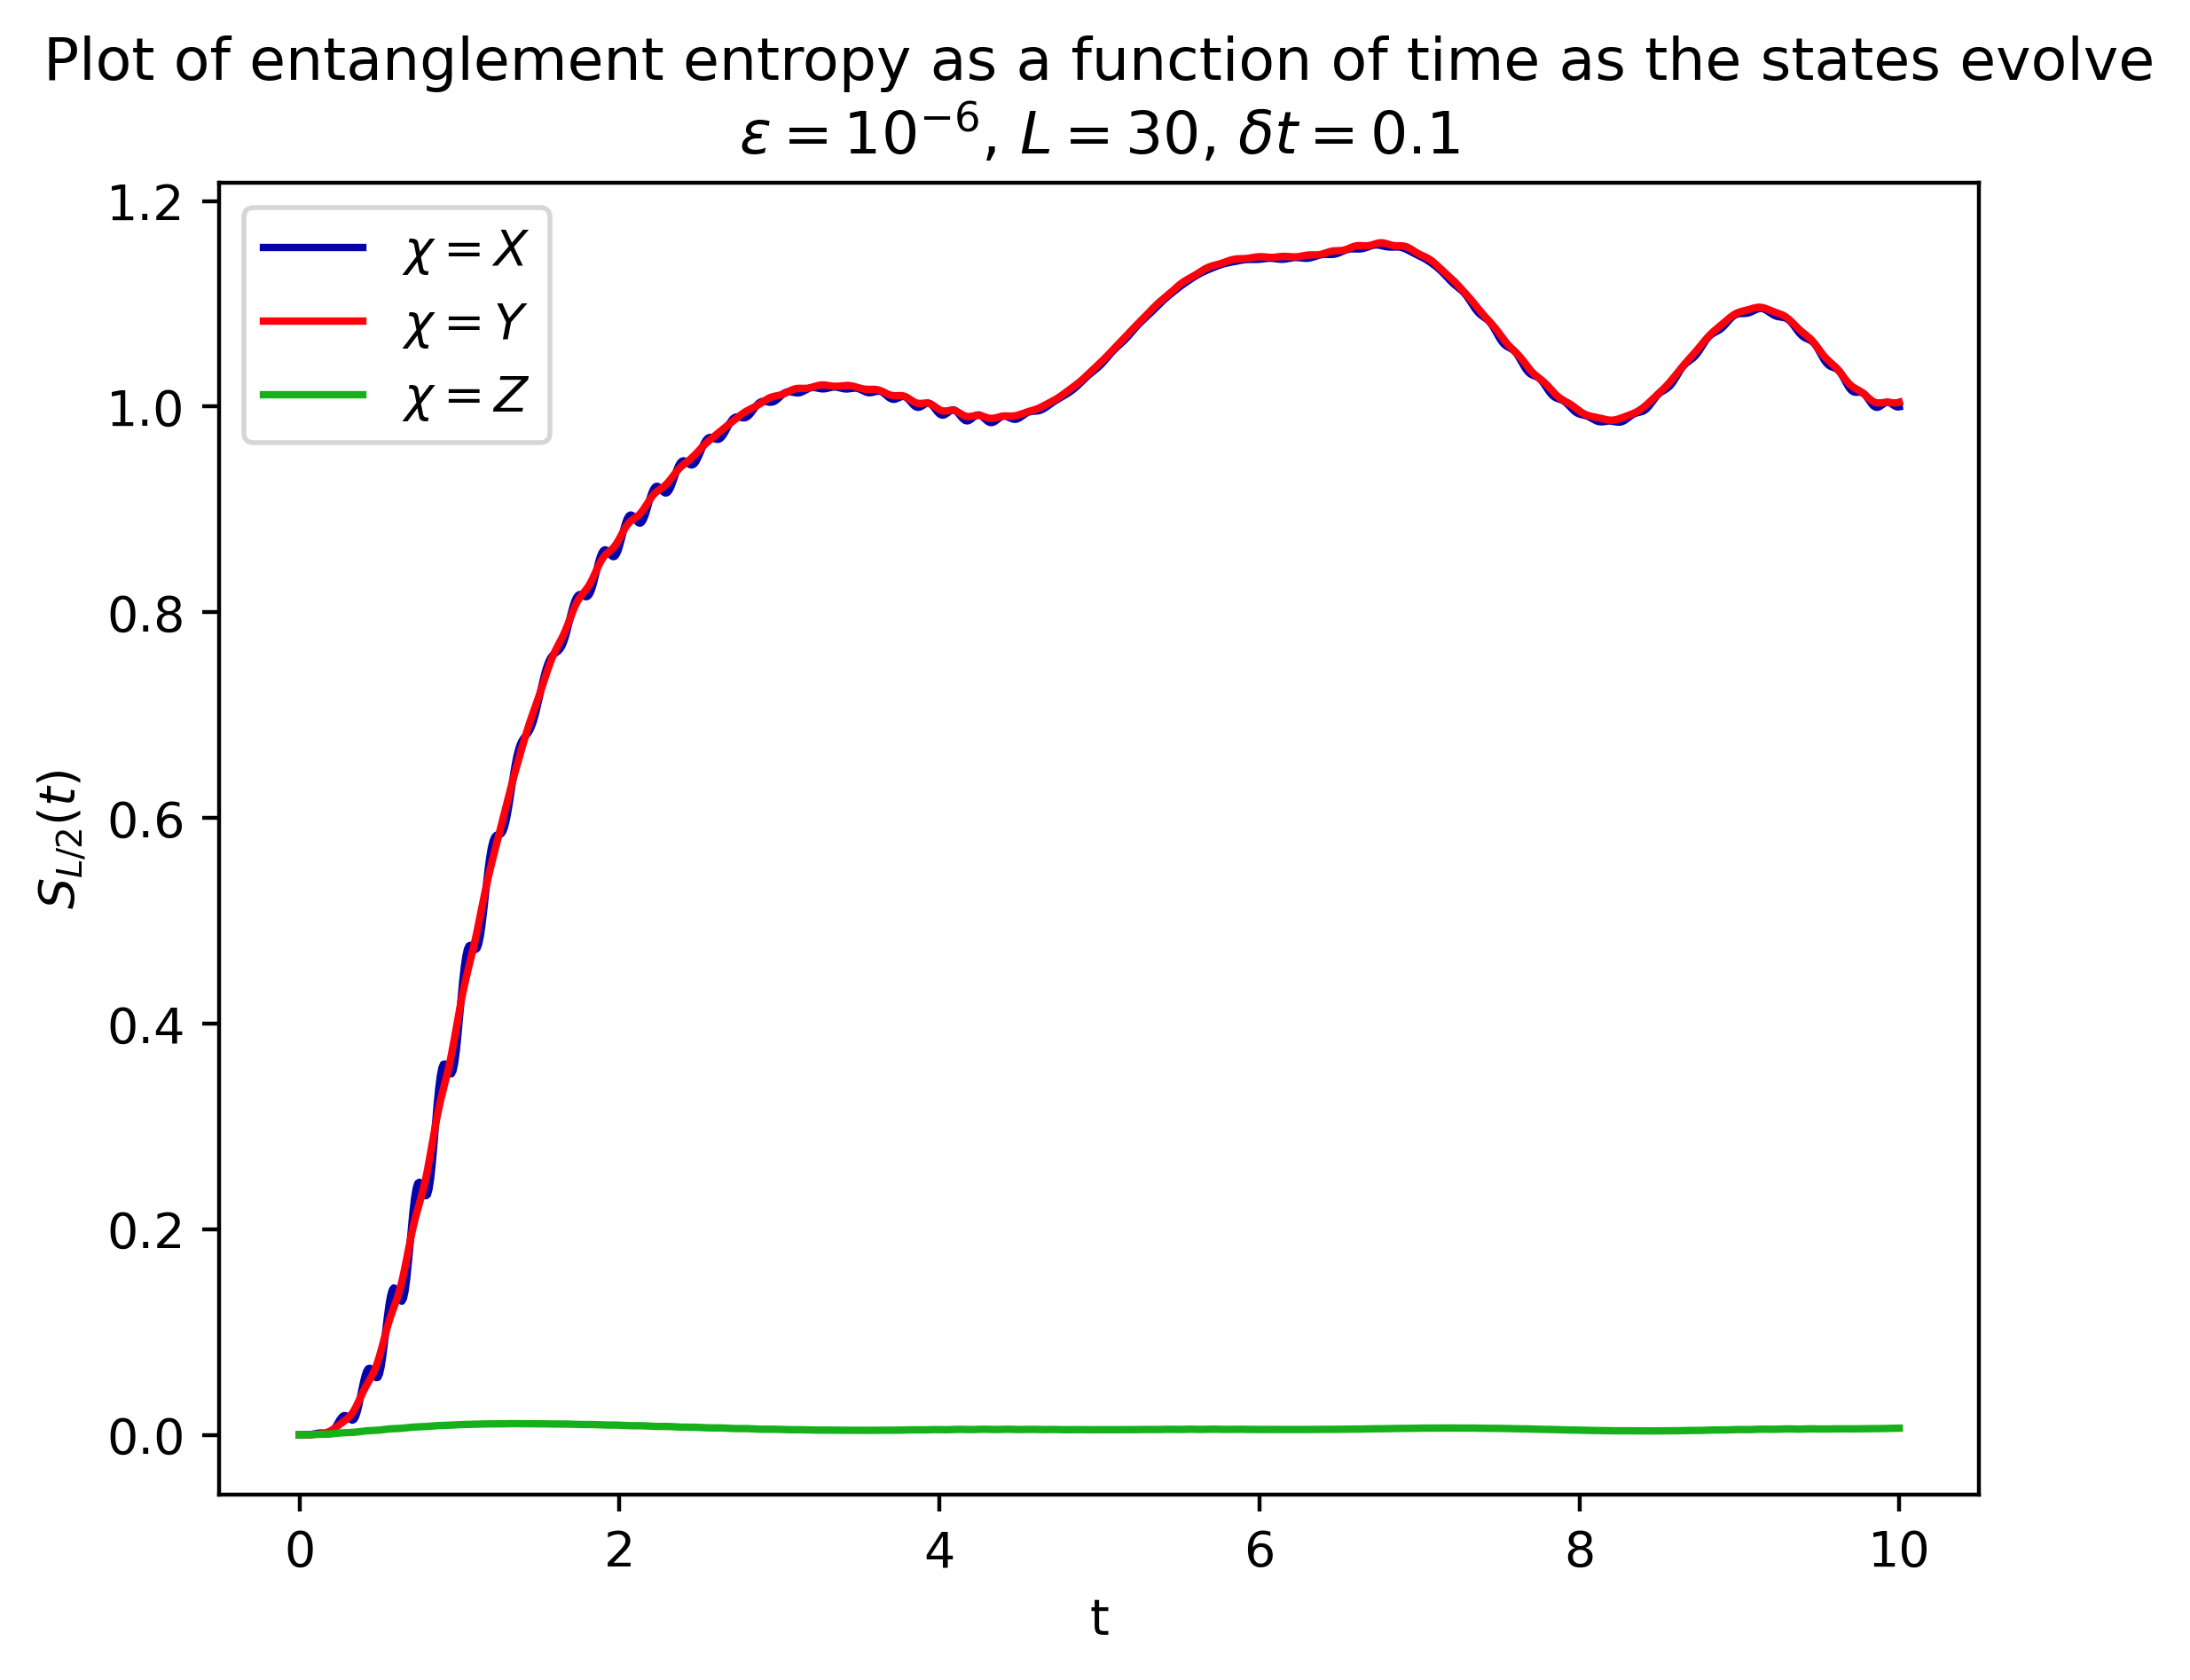

In [44]:
entropies_1 = []
entropies_2 = []
entropies_3 = []

for i in tqdm(range(len(canonical_trackersX)), desc="Computing Entropies"):
    entropy = entanglement_entropy(L//2, canonical_trackersX[i])
    entropies_1.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackersY[i])
    entropies_2.append(entropy)
    
    entropy = entanglement_entropy(L//2, canonical_trackersZ[i])
    entropies_3.append(entropy)
    

    
plt.plot(np.arange(0, len(canonical_trackersX), 1)*dt, entropies_1, color='xkcd:royal blue', label=r'$\chi=X$')
plt.plot(np.arange(0, len(canonical_trackersX), 1)*dt, entropies_2, color='xkcd:bright red', label=r'$\chi=Y$')
plt.plot(np.arange(0, len(canonical_trackersX), 1)*dt, entropies_3, color='xkcd:green', label=r'$\chi=Z$')

plt.title('Plot of entanglement entropy as a function of time as the states evolve'+'\n$\epsilon = 10^{-6}$, $L = 30$, $\delta t = 0.1$')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$S_{L/2}(t)$')
# plt.savefig(os.path.join(directory, 'entropyp2.png'), dpi=400)


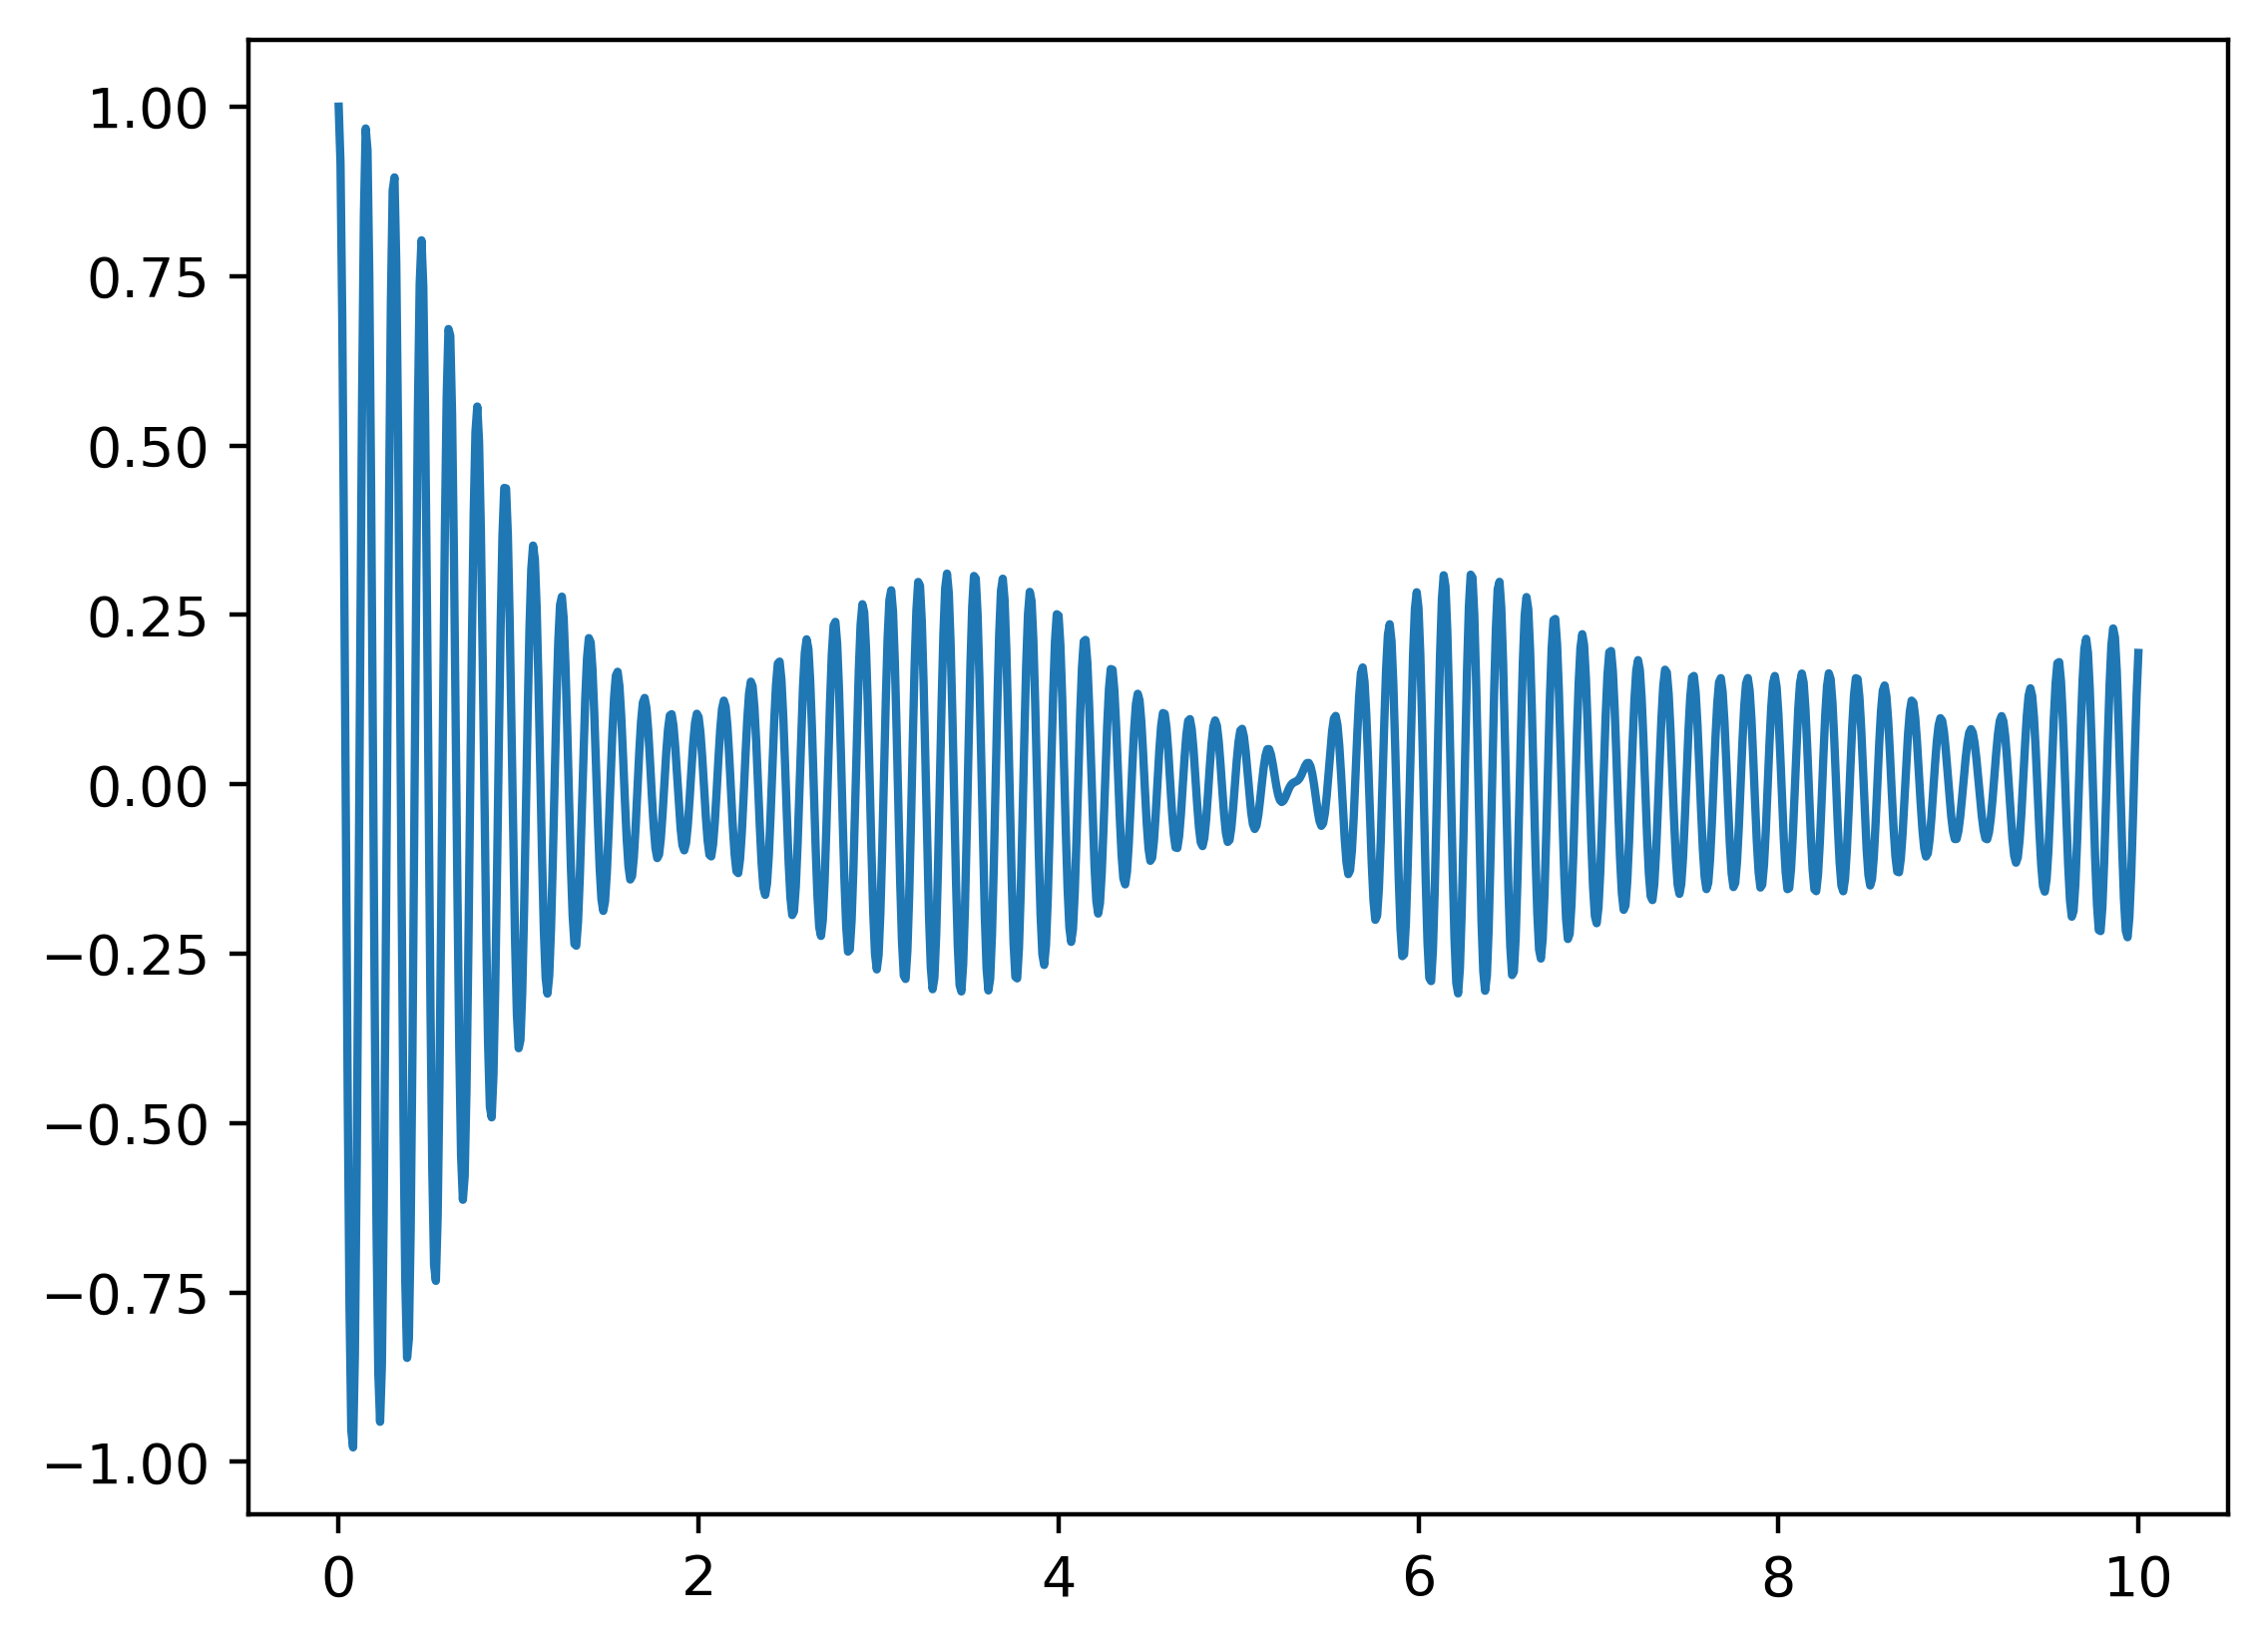

In [46]:
plt.plot(np.arange(0, len(sigma_xs), 1)*(10/1000), sigma_xs)

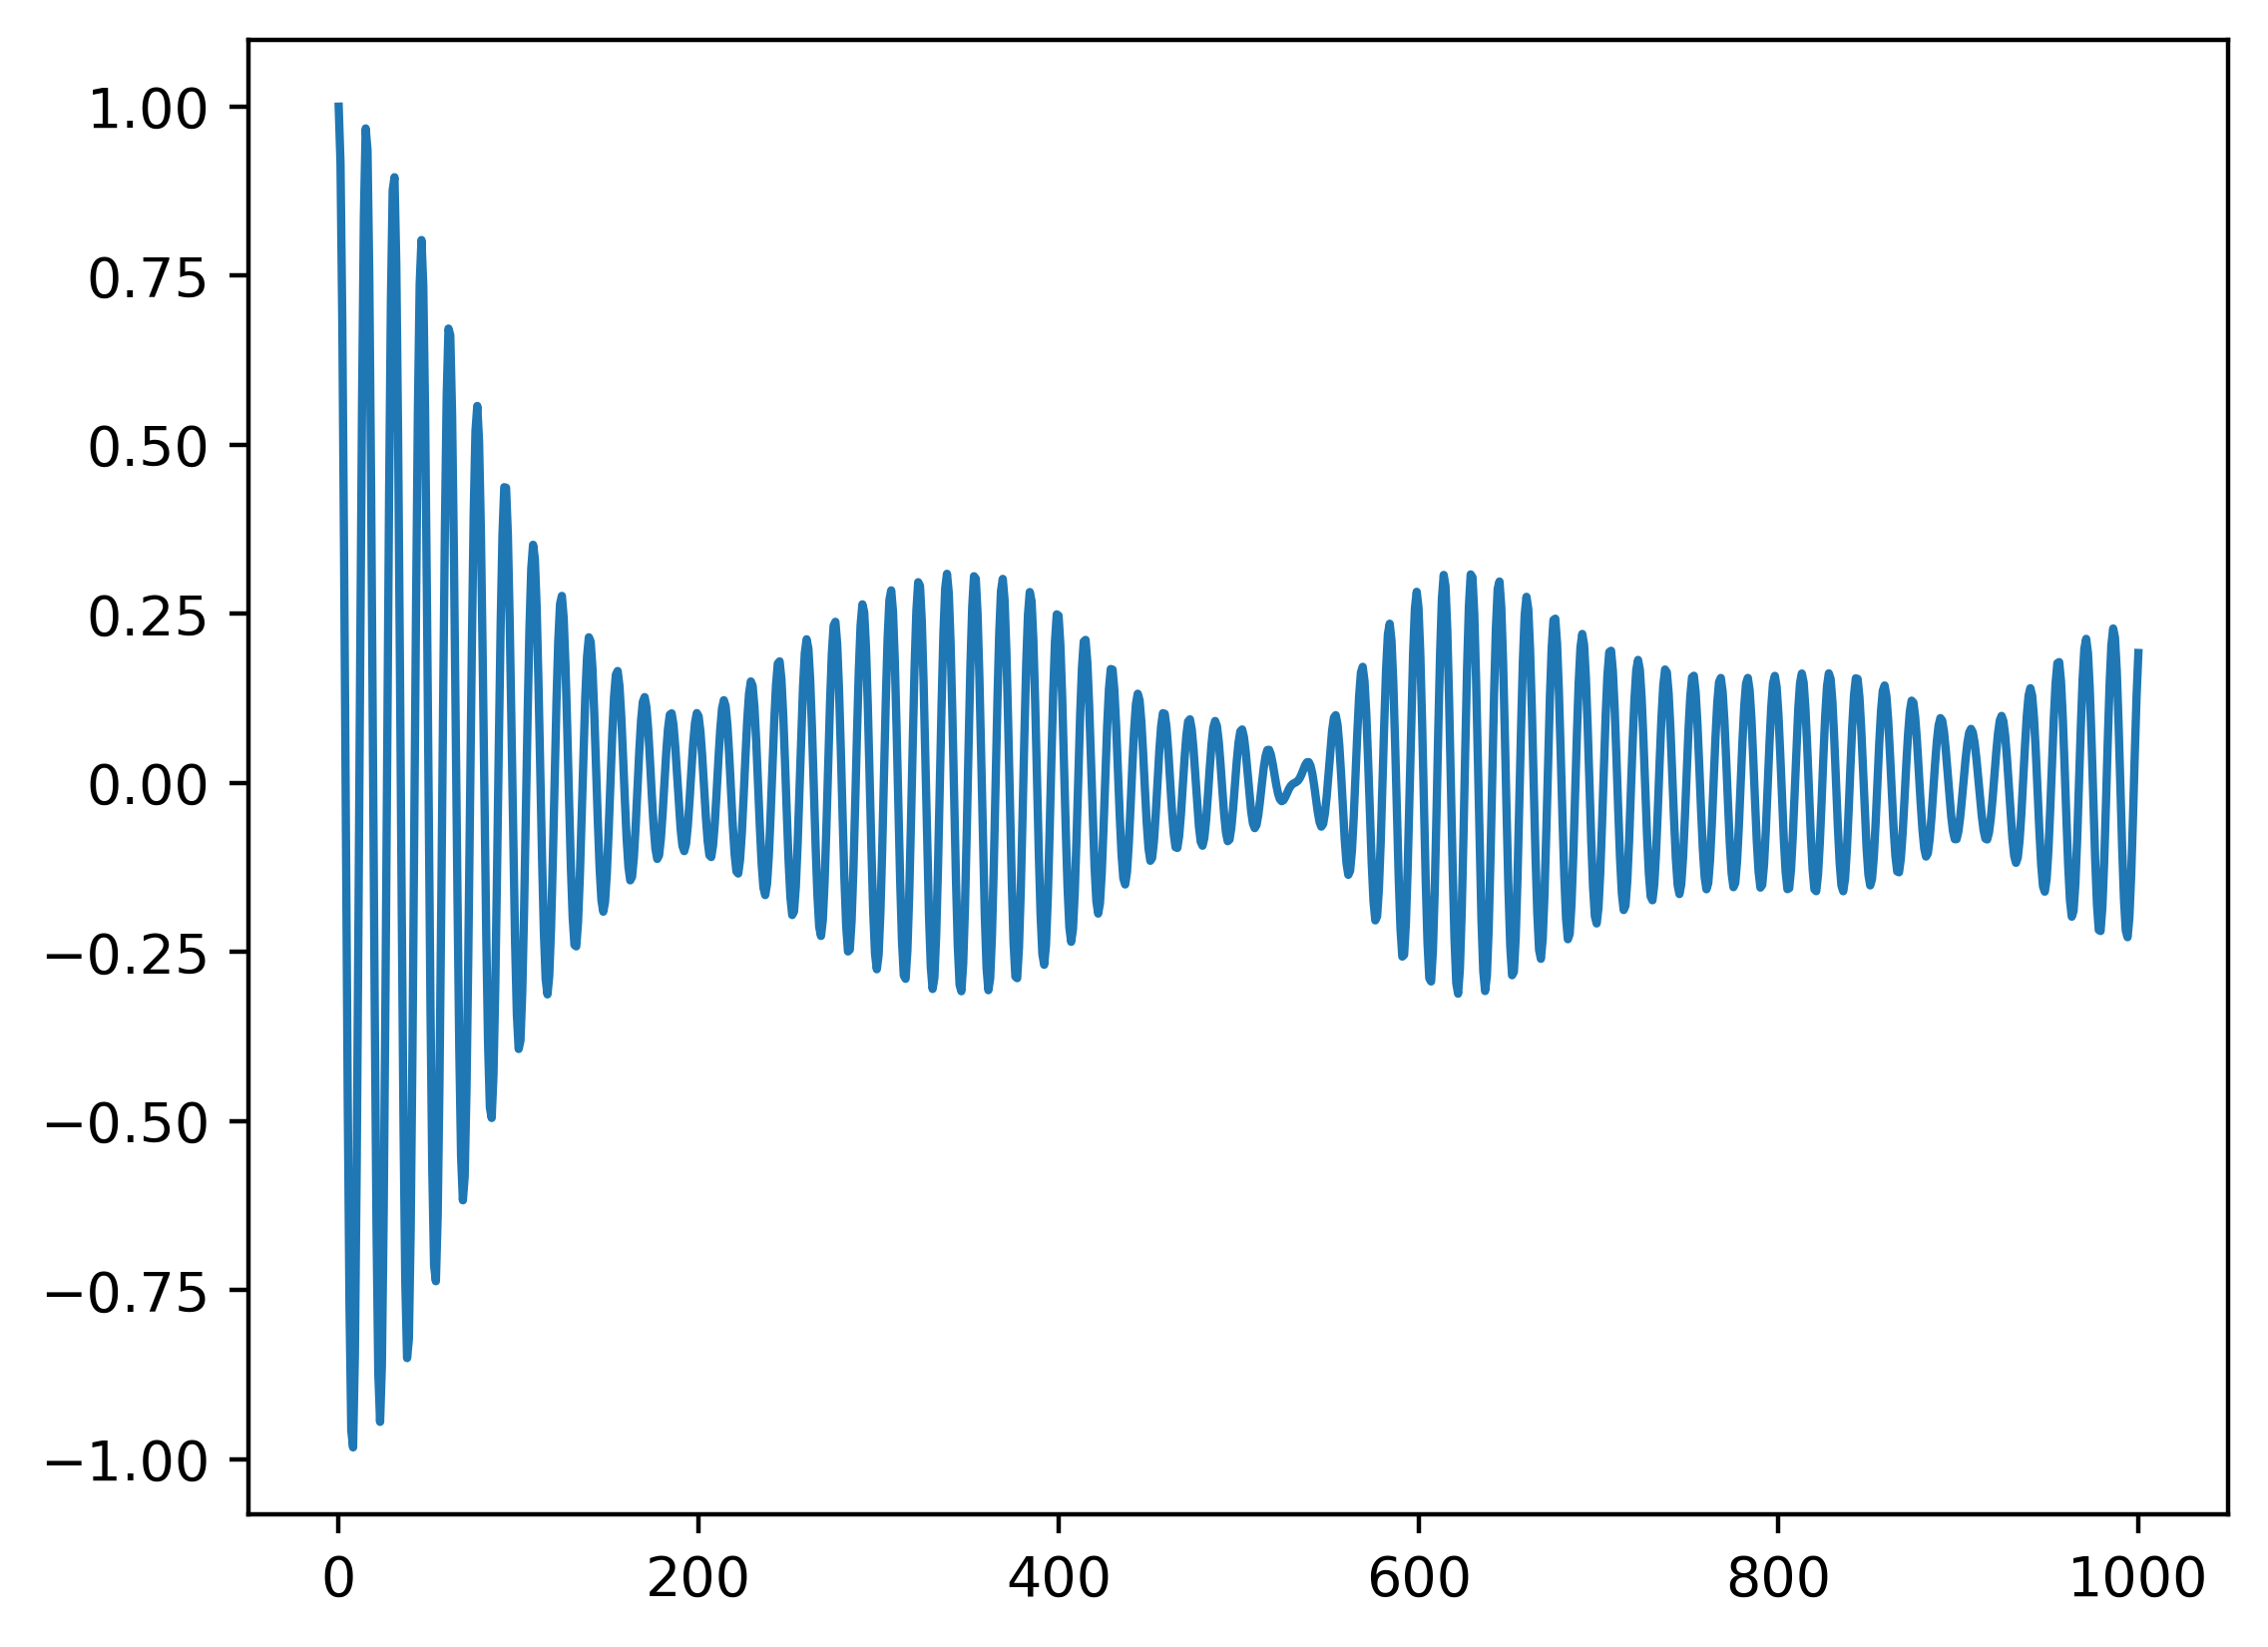

In [47]:
plt.plot(np.arange(0, len(sigma_ys), 1), sigma_ys)

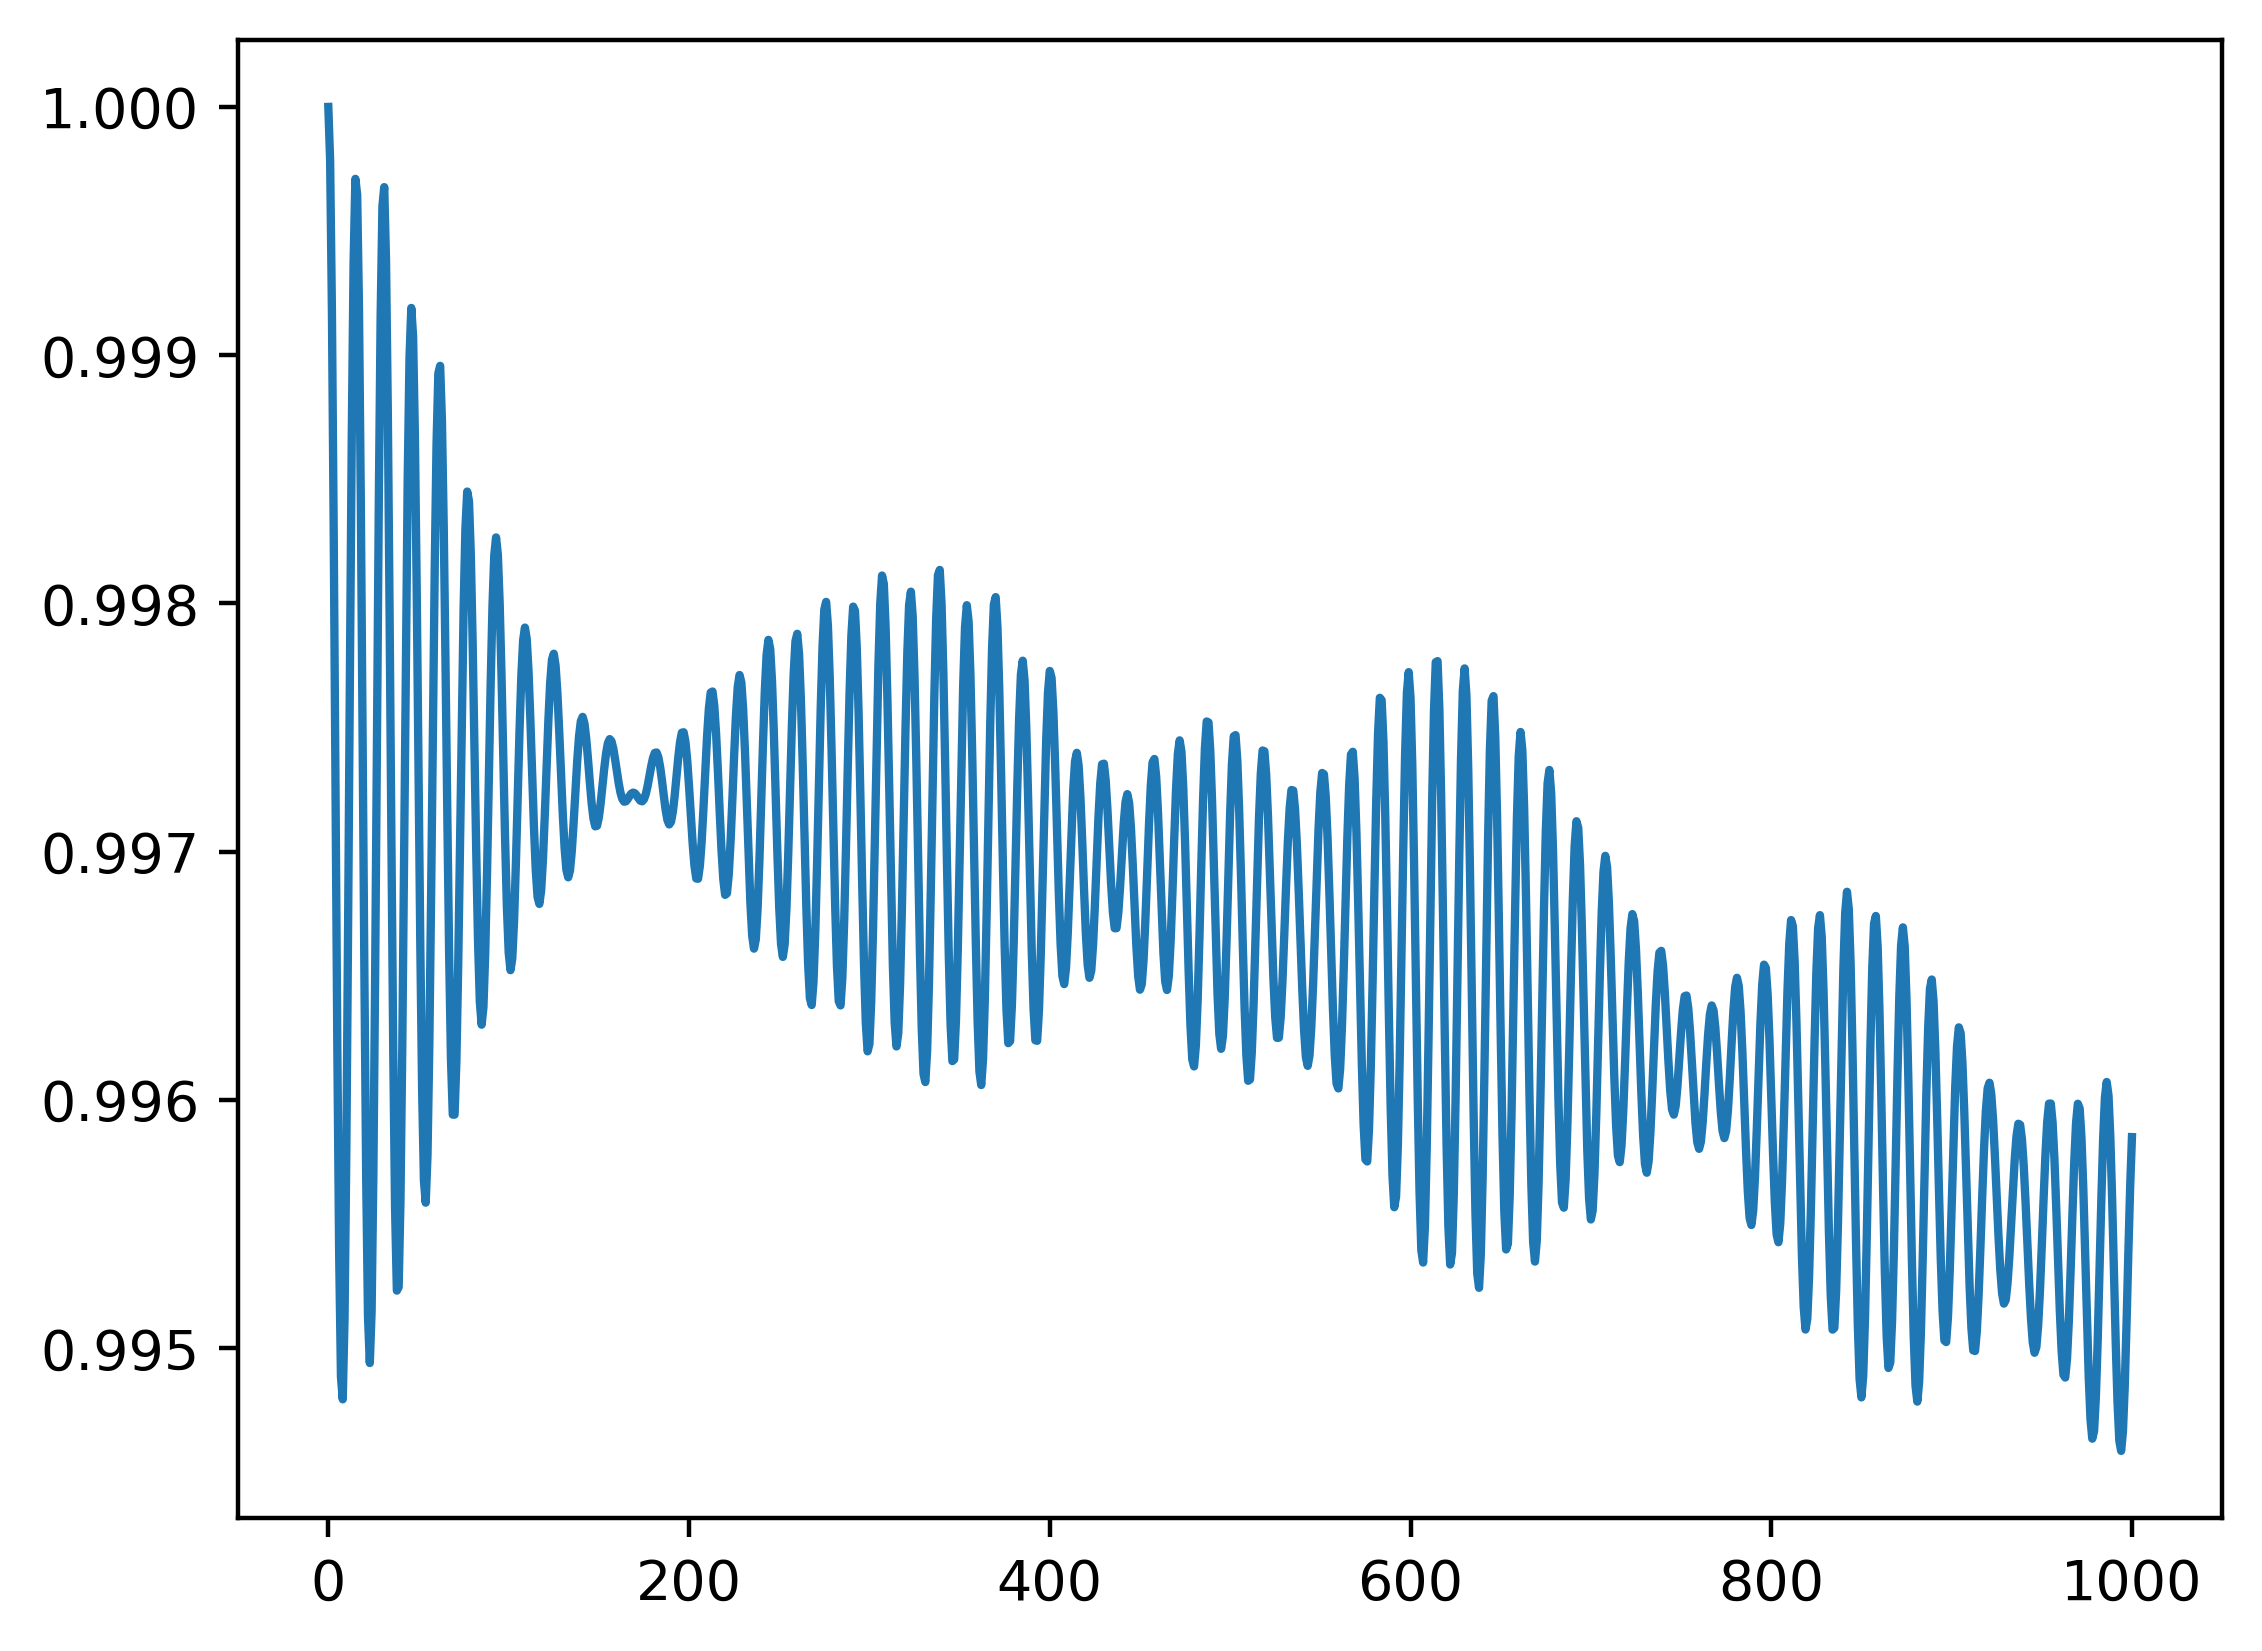

In [48]:
plt.plot(np.arange(0, len(sigma_zs), 1), sigma_zs)

In [ ]:
L = 32
J = 1
hx = -1.05
hz = 0
periodic = False 
dt = 0.01
chi = 16


ket = ferromagnetic_state_MPS(L)

ground_state_energy, evolved_ket, energies_001, canonical_tracker = ground_state(-1j*dt, J, hx, hz, ket, chi, 1e-6, max_iterations=2000)



In [298]:
ground_state_energy

(-54.406654535941456+0j)

In [ ]:
sigma_xs, sigma_ys, sigma_zs = correlator_evolution(evolved_ket, ground_state_energy, 10, L//2, 1000, 64)

In [ ]:
plt.plot(np.arange(0, len(sigma_xs), 1)*(10/1000), sigma_xs)

In [ ]:
plt.plot(np.arange(0, len(sigma_ys), 1), sigma_ys)

In [ ]:
plt.plot(np.arange(0, len(sigma_zs), 1), sigma_zs)